In [ ]:
!pip install shap -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Customer_Churn_Prediction')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from split import split_data
from error_analysis import classification_summary
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Customer_Churn_Prediction/Telco-Customer-Churn-Final.csv")

In [ ]:
x = df.drop(columns="Churn", errors="ignore")
y = df["Churn"].astype(int)

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x,y)

In [ ]:
lr_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False) if hasattr(x_train, "sparse") else StandardScaler()),
    ("model", LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear"))
])
_ = lr_model.fit(x_train, y_train)

In [ ]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    scale_pos_weight=ratio,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

_ = xgb_model.fit(x_train, y_train)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=10,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)
_ = rf.fit(x_train, y_train)

In [ ]:
p_lr  = lr_model.predict_proba(x_val)[:, 1]
p_xgb = xgb_model.predict_proba(x_val)[:, 1]
p_rf  = rf.predict_proba(x_val)[:, 1]

p_ens = 0.5*p_xgb + 0.5*p_rf

prec, rec, thr = precision_recall_curve(y_val, p_ens)
f1s = 2 * prec * rec / (prec + rec + 1e-12)

best_idx = np.argmax(f1s)
best_thr = thr[best_idx - 1] if best_idx > 0 else 0.5

y_pred = (p_ens >= best_thr).astype(int)

print("Best threshold:", best_thr)
print("Val F1 (soft vote):", f1_score(y_val, y_pred))

Best threshold: 0.39174267538245766
Val F1 (soft vote): 0.8516242317822651


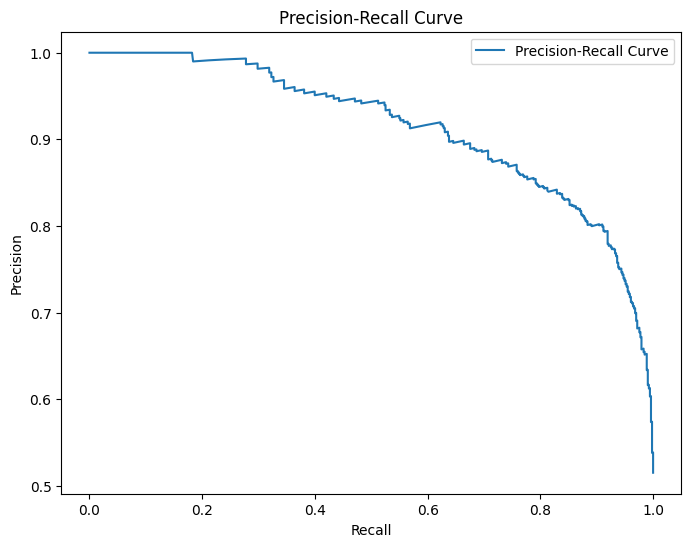

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, label=f'Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
joblib.dump(xgb_model, "/content/drive/MyDrive/Customer_Churn_Prediction/xgb_model.pkl")
joblib.dump(rf, "/content/drive/MyDrive/Customer_Churn_Prediction/rf_model.pkl")

ensemble_config = {
    "weights": {
        "xgb": 0.5,
        "rf": 0.5
    },
    "threshold": best_thr
}

joblib.dump(ensemble_config, "/content/drive/MyDrive/Customer_Churn_Prediction/ensemble_config.pkl")

In [ ]:
import shap

# Initialize Explainers
# XGBoost is very fast with TreeExplainer
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb(x_val)

# Random Forest can be slower; we use the same TreeExplainer
# Note: RF explainers in SHAP often return a list [Class 0, Class 1]. We want Class 1.
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf_all = explainer_rf(x_val)

# Handle shape differences:
# XGBoost usually gives (n_samples, n_features)
# Sklearn RF usually gives (n_samples, n_features, n_classes) -> we select index [:,:,1] for churn
if len(shap_values_rf_all.shape) == 3:
    shap_values_rf = shap_values_rf_all[:, :, 1]
else:
    shap_values_rf = shap_values_rf_all

# --- CREATE ENSEMBLE EXPLANATION ---
# Since your model is 0.5 * XGB + 0.5 * RF, the explanation is the same math!
shap_values_ensemble = shap_values_xgb # Create a copy structure
shap_values_ensemble.values = (shap_values_xgb.values * 0.5) + (shap_values_rf.values * 0.5)
shap_values_ensemble.base_values = (shap_values_xgb.base_values * 0.5) + (shap_values_rf.base_values * 0.5)

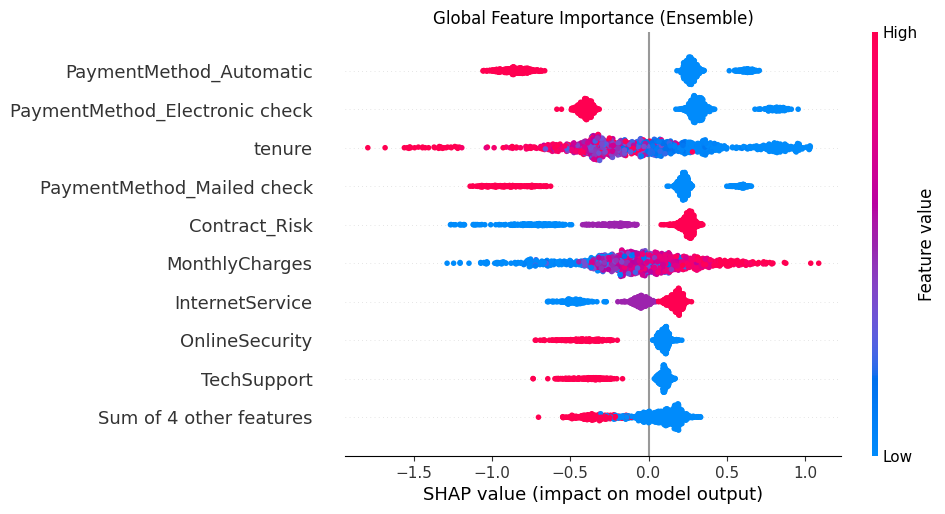

In [ ]:
# Summary Plot (Beeswarm)
plt.title("Global Feature Importance (Ensemble)")
shap.plots.beeswarm(shap_values_ensemble)

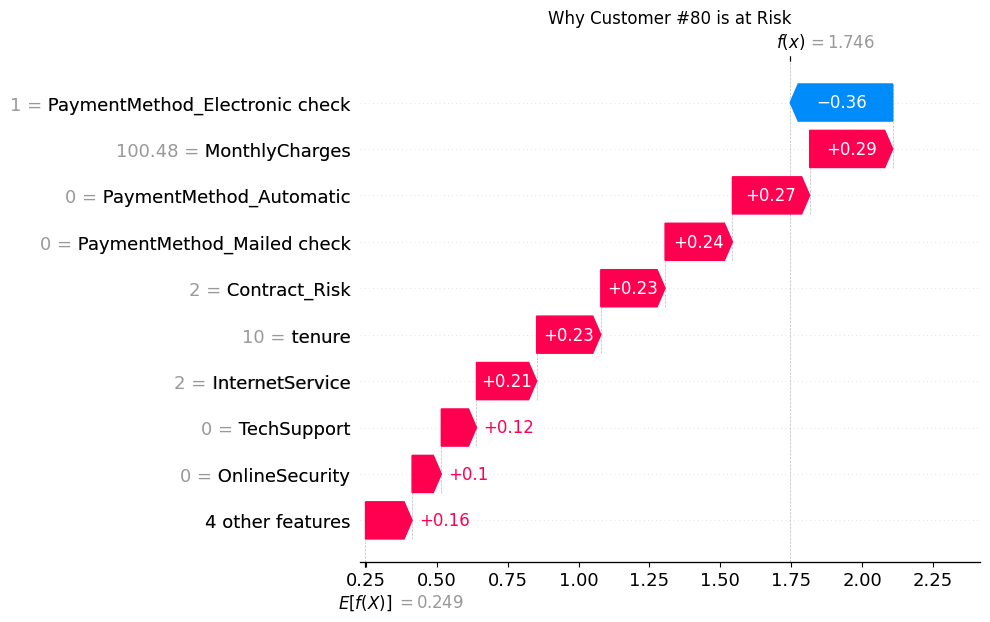

In [ ]:
# Pick a specific customer index (e.g., index 10)
customer_idx = 80

# Waterfall Plot
plt.title(f"Why Customer #{customer_idx} is at Risk")
shap.plots.waterfall(shap_values_ensemble[customer_idx])